In [1]:
import argparse
import numpy as np
import os
import sys
import time
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid

from unet import UNet
from mnist_unet import MNISTUnet
#from scripts.karras_unet import KarrasUnet
from scripts.bansal_unet import BansalUnet
from scripts.vae_unet import VAEUNet
from scripts.risannen_unet import RisannenUnet
from scripts.risannen_unet_vae import VAEUnet
from diffusion_utils import Degradation, Trainer, Sampler, ExponentialMovingAverage, DCTBlurSampling
from utils import load_dataset, create_dirs, save_video, save_gif, MyCelebA


import ipywidgets as widgets
from IPython.display import display

import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Check if ipykernel is running to check if we're working locally or on the cluster
import sys
if 'ipykernel' in sys.modules:
    sys.argv = ['']

In [2]:

parser = argparse.ArgumentParser(description='Diffusion Models')

# General Diffusion Parameters
parser.add_argument('--timesteps', '--t', type=int, default=200, help='Degradation timesteps')
parser.add_argument('--prediction', '--pred', type=str, default='xt', help='Prediction method, choose one of [x0, xt, residual]')
parser.add_argument('--dataset', type=str, default='afhq', help='Dataset to run Diffusion on. Choose one of [mnist, cifar10, celeba, lsun_churches]')
parser.add_argument('--degradation', '--deg', type=str, default='fadeblack_blur', help='Degradation method')
parser.add_argument('--batch_size', '--b', type=int, default=32, help='Batch size')
parser.add_argument('--dim', '--d', type=int , default=128, help='Model dimension')
parser.add_argument('--lr', type=float, default=1e-4, help='Learning rate')
parser.add_argument('--epochs', '--e', type=int, default=20, help='Number of Training Epochs')
parser.add_argument('--noise_schedule', '--sched', type=str, default='cosine', help='Noise schedule')
parser.add_argument('--loss_weighting', action='store_false', help='Whether to use weighting for reconstruction loss')
parser.add_argument('--var_sampling_step', type=int, default = 1, help='How to sample var timestep model - int > 0 indicates t difference to predict, -1 indicates x0 prediction')
parser.add_argument('--min_t2_step', type=int, default=1, help='With what min step size to discretize t2 in variational timestep model') 
parser.add_argument('--baseline', '--base', type=str, default='xxx', help='Whether to run a baseline model - Risannen, Bansal, VAE')

# Noise Injection Parameters
parser.add_argument('--vae', action='store_true', help='Whether to use VAE Noise injections')
parser.add_argument('--vae_alpha', type=float, default = 0.999, help='Trade-off parameter for weight of Reconstruction and KL Div')
parser.add_argument('--latent_dim', type=int, default=128, help='Which dimension the VAE latent space is supposed to have')
parser.add_argument('--add_noise', action='store_false', help='Whether to add noise Risannen et al. style')
parser.add_argument('--break_symmetry', action='store_true', help='Whether to add noise to xT Bansal et al. style')
parser.add_argument('--noise_scale', type=float, default = 0.01, help='How much Noise to add to the input')
parser.add_argument('--vae_loc', type=str, default = 'start', help='Where to inject VAE Noise. One of [start, bottleneck, emb].')
parser.add_argument('--vae_inject', type=str, default = 'add', help='How to inject VAE Noise. One of [concat, add].')
parser.add_argument('--xt_dropout', type=float, default = 0.2, help='How much of xt is dropped out at every step (to foster reliance on VAE injections)')

# Housekeeping Parameters
parser.add_argument('--load_checkpoint', action='store_true', help='Whether to try to load a checkpoint')
parser.add_argument('--sample_interval', type=int, help='After how many epochs to sample', default=1)
parser.add_argument('--n_samples', type=int, default=5, help='Number of samples to generate')
parser.add_argument('--fix_sample', action='store_false', help='Whether to fix x_T for sampling, to see sample progression')
parser.add_argument('--skip_ema', action='store_true', help='Whether to skip model EMA')
parser.add_argument('--model_ema_decay', type=float, default=0.997, help='Model EMA decay')
parser.add_argument('--cluster', action='store_true', help='Whether to run script locally')
parser.add_argument('--skip_wandb', action='store_true', help='Whether to skip wandb logging')
parser.add_argument('--verbose', '--v', action='store_true', help='Verbose mode')

parser.add_argument('--test_run', action='store_true', help='Whether to test run the pipeline')

args = parser.parse_args()

args.num_downsamples = 2 if args.dataset == 'mnist' else 3
args.device = 'cuda' if torch.cuda.is_available() else 'mps'

if 'mnist' in args.dataset:
    args.image_size = 28
elif args.dataset == 'cifar10':
    args.image_size = 32
elif args.dataset == 'afhq':
    args.image_size = 64

if args.vae:
    print("Using VAE Noise Injections")
    assert not args.add_noise, "Cannot use VAE and add noise at the same time"
else:
    if args.add_noise:
        print("Using Risannen Noise Injections")
    else:
        print("Using Normal U-Net")

if not args.cluster:
    print("Running locally, Cluster =", args.cluster)
    if args.device == 'cuda':
        warnings.warn('Consider running model on cluster-scale if CUDA is available')

if args.test_run:
    print("Running Test Run with only one iter per epoch")

print("Device: ", args.device)


kwargs = vars(args)

trainloader, valloader = load_dataset(kwargs['batch_size'], kwargs['dataset'])

x, _ = next(iter(trainloader))   
channels = x[0].shape[0]

# Model Configuration
if 'mnist' in kwargs['dataset']:
    attention_levels = (2,)
    ch_mult = (1,2,2)
    num_res_blocks = 2
elif kwargs['dataset'] == 'cifar10':
    attention_levels = (2,3)
    ch_mult = (1, 2, 2, 2)
    num_res_blocks = 4
elif kwargs['dataset'] == 'afhq':
    attention_levels = (2,3)
    ch_mult = (1, 2, 3, 4)
    num_res_blocks = 2
elif kwargs['dataset'] == 'celeba':
    attention_levels = (2,3)
    ch_mult = (1, 2, 2, 2)
elif kwargs['dataset'] == 'lsun_churches':
    attention_levels = (2,3,4)
    ch_mult = (1, 2, 3, 4, 5)
    num_res_blocks = 4


# Define Model
if kwargs['vae']:


    # Risannen Version
    unet = VAEUnet(image_size=kwargs["image_size"],
                    in_channels=channels,
                    dim=kwargs['dim'],
                    num_res_blocks=num_res_blocks,
                    attention_levels=attention_levels,
                    dropout=0,
                    ch_mult=ch_mult,
                    latent_dim = kwargs['latent_dim'],
                    noise_scale= kwargs['noise_scale'],
                    var_timestep=True if kwargs['prediction'] == 'vxt' else False,
                    vae_loc = kwargs['vae_loc'],
                    vae_inject = kwargs['vae_inject'],
                    xt_dropout = kwargs['xt_dropout'])

else:

    unet = RisannenUnet(image_size=kwargs["image_size"],
                        in_channels=channels,
                        dim=kwargs['dim'],
                        num_res_blocks=num_res_blocks,
                        attention_levels=attention_levels,
                        dropout=0,
                        ch_mult=ch_mult,
                        var_timestep=True if kwargs['prediction'] == 'vxt' else False)

Using Risannen Noise Injections
Running locally, Cluster = False
Device:  mps


In [3]:

# Define Trainer and Sampler
trainer = Trainer(model = unet, **kwargs)
sampler = Sampler(**kwargs)

# Fit GMM for cold sampling in deblurring diffusion
if kwargs['degradation'] == 'blur':
    sampler.fit_gmm(trainloader, clusters=1)

# Fix x_T for sampling
if kwargs['fix_sample']:
    sampler.sample_x_T(kwargs['n_samples'], channels, kwargs['image_size'])

# Create directories
imgpath, modelpath = create_dirs(**kwargs)

# imgpath = imgpath.replace('imgs', 'imgs/control').split('run')[0]
# imgpath = os.path.join(imgpath, 'control')
# if not os.path.exists(imgpath):
#     os.makedirs(imgpath)

ema_flag = '' if kwargs['skip_ema'] else '_ema'
manual_extension = 'risannen'

# Load Checkpoint
try:
    chkpt = torch.load(os.path.join(f"./models/models_to_test/{kwargs['dataset']}/{kwargs['degradation']}", f"chpkt_{kwargs['dim']}_{kwargs['timesteps']}_{kwargs['prediction']}{ema_flag}_{manual_extension}.pt"), map_location=kwargs['device'])
    trainer.model.load_state_dict(chkpt['model_state_dict'])
    trainer.optimizer.load_state_dict(chkpt['optimizer_state_dict'])
    trainer.model_ema.load_state_dict(chkpt['ema_state_dict'])
        
    # Replace model params with EMA params 
    trainer.model_ema.copy_to(trainer.model.parameters()) # Copy EMA params to model
    
    print("Checkpoint loaded, model trained until epoch", chkpt['epoch'])
except Exception as e:
    raise ValueError("No checkpoint found, please choose pretrained variable timestep model to control VAE injections.")

# EMA Transfer
trainer.model.eval()
trainer.model_ema.copy_to(trainer.model.parameters()) # Copy EMA params to model for inference
print("EMA transferred to model")



x_T sampled and fixed
Checkpoint loaded, model trained until epoch 930
EMA transferred to model


In [4]:
class StyleSampler():

    def __init__(self, trainer, **kwargs):
        self.model = trainer.model
        self.trainer = trainer
        self.timesteps = kwargs['timesteps']
        self.T = torch.full((kwargs['n_samples'],), self.timesteps-1, dtype=torch.long).to(kwargs['device'])
        self.xT = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device']) 
        self.target_prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.source_prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.dct = DCTBlurSampling(sampler.degradation.dct_blur.blur_sigmas, kwargs['image_size'], kwargs['device'])

    
    @torch.no_grad()
    def full_loop(self, step_size, injection_t = [200, 50], x0 = None, x02 = None, plot = True, bansal_sampling = True, **kwargs):
        
        xt = self.xT
        samples = torch.Tensor(xt[0:5])
        
        # Bansal-style sampling
        if bansal_sampling:
            skip_steps = 1
            bansal_flag = "Bansal"
        else:
            skip_steps = step_size-1 if step_size == self.timesteps else step_size
            bansal_flag = "Regular"
            
        # Loop differs from the sequential one, as we go back to t-1 at every step
        for i in tqdm(range(self.timesteps-1, -1, -skip_steps), total = self.timesteps // skip_steps, desc = f'Sampling {bansal_flag} with step size of {step_size}'):
            
            t = torch.full((kwargs['n_samples'],), i, dtype=torch.long).to(kwargs['device'])
            t2 = torch.full((kwargs['n_samples'],), i-step_size, dtype=torch.long).to(kwargs['device'])
            
            if t2[0].item() < 0: # Equals to x0 prediction
                t2 = torch.full((kwargs['n_samples'],), -1, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training

            # if not bansal_sampling:
            #     print(f"t = {t[0].item()}, t2 = {t2[0].item()}")
            
            # Inject source information in a certain t range
            # if x0 and / or x02 are not None, take the conditioning information from the encoded data,
            if i < injection_t[0] and i > injection_t[1]:
                if x02 is not None:
                    xt2 = self.trainer.degradation.degrade(x02, t)
                    cond2 = self.trainer.degradation.degrade(x02, t2)
                    dummy_pred = self.model(xt2, t, cond=cond2, prior=None, t2=t2).detach() # Dummy prediction to get the encoded VAE latent
                    prior = self.model.vae_noise.detach() 
                else:
                    prior = self.source_prior 
                cond = None # No condition for the model, such that is has to use the prior
            else:
                if x0 is not None:
                    cond = self.trainer.degradation.degrade(x0, t2)
                    prior = None # No prior for the model, such that it has to use the condition
                else:
                    cond = None
                    prior = self.target_prior

            pred = self.model(xt, t, cond=cond, prior=prior, t2=t2)
            pred = pred.detach()
            
            xtm1_model = xt + pred
            samples = torch.cat((samples, xtm1_model[0:5]), dim=0)

            # Bansal Part
            if bansal_sampling:
                if step_size == self.timesteps:
                    
                    xt_hat = sampler.degradation.degrade(xtm1_model, t)
                    xtm1_hat = sampler.degradation.degrade(xtm1_model, t-1)
                    
                else:

                    # Calculcate reblurring for DCT
                    stdt = sampler.degradation.blur.dct_sigmas[t[0].item()]
                    stdtm1 = sampler.degradation.blur.dct_sigmas[t[0].item()-1]
                    stdt2 = sampler.degradation.blur.dct_sigmas[t2[0].item()] if t2[0].item() != -1 else 0

                    # Manually calculating DCT timesteps
                    t_dct = torch.full((kwargs['n_samples'],), stdt**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    tm1_dct = torch.full((kwargs['n_samples'],), stdtm1**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    t2_dct = torch.full((kwargs['n_samples'],), stdt2**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    
                    # Calculate DCT differences to get to t / t-1 from t2
                    t_diff_dct = t_dct - t2_dct
                    tm1_diff_dct = tm1_dct - t2_dct

                    # Undo Blacking
                    blacking_coef = sampler.degradation.blacking_coefs[t2[0].item()] if t2[0].item() != -1 else 1
                    xtm1_model = xtm1_model / blacking_coef

                    # Reblur to t / t-1 from t2
                    xt_hat = self.dct(xtm1_model, t=t_diff_dct) 
                    xtm1_hat = self.dct(xtm1_model, t=tm1_diff_dct)

                    # Reapply Blacking
                    xt_hat = xt_hat * sampler.degradation.blacking_coefs[t[0].item()]
                    xtm1_hat = xtm1_hat * sampler.degradation.blacking_coefs[t[0].item() - 1]

                    # Check for NAs
                    assert not torch.isnan(xtm1_hat).any() 

                    if t[0].item()-1 == -1:
                        xtm1_hat = xtm1_model # Keep the original image for t=-1 (needed for Bansal style sampling)
                        #assert torch.equal(xtm1_hat[0], xtm1_model[0]), f"DCT reblurring failed, xtm1_hat is not equal to xtm1_model with xtm1_hat = {xtm1_hat[0,0,0]} and xtm1_model = {xtm1_model[0,0,0]}"

                xt = xt - xt_hat + xtm1_hat # Counter the bias of the model prediction by having it incorporated two times in the sampling process
                samples = torch.cat((samples, xt[0:5]), dim=0)

            else:
                xt = xtm1_model
                #samples = torch.cat((samples, xt[0:5]), dim=0)
                if t[0].item() < step_size:
                    break
        
        if plot:
            self.plot(xt)
            save_gif(samples[::5,:,:], f'./imgs/experiment_imgs', nrow = 1, name = f"sample_DCT_{bansal_flag}_{step_size}.gif")

        return samples, xt
    



    def plot(self, input):
        plt.figure(figsize=(20, 10))
        grid = make_grid(input, nrow=10, padding=0)
        grid = torch.clamp(grid, 0, 1)
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()


style_sampler = StyleSampler(trainer, **kwargs)

Sampling Bansal with step size of 200: 100%|██████████| 200/200 [00:30<00:00,  6.53it/s]


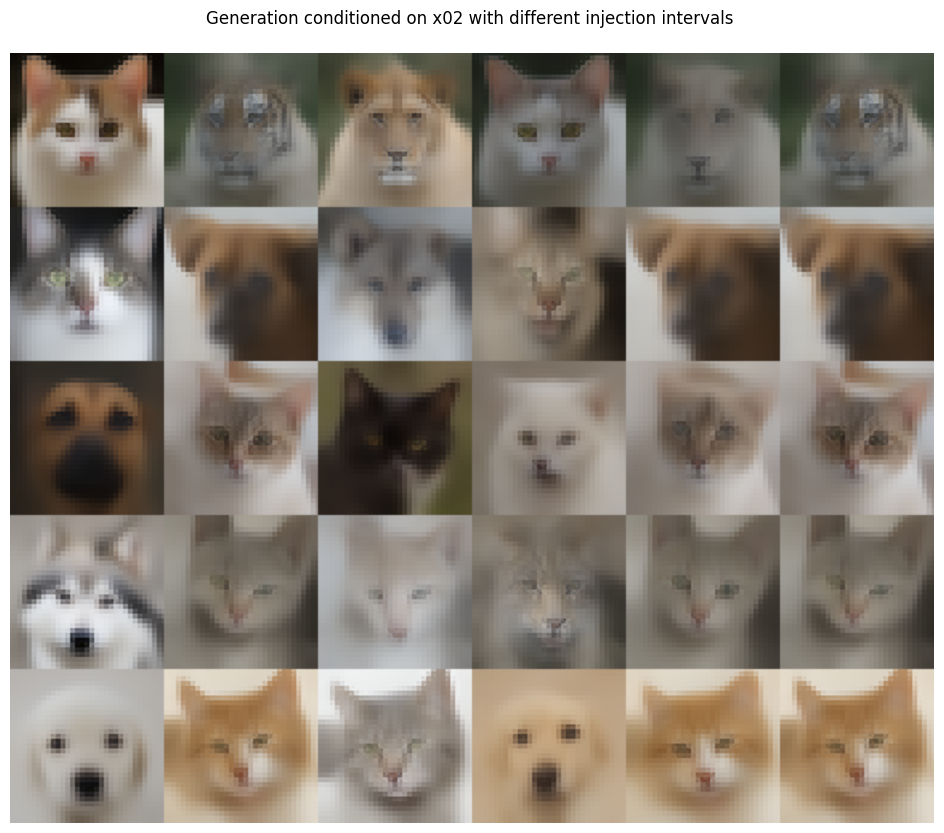

In [29]:
use_x0 = False
use_x02 = True
num_rows = 6

if use_x0:
    x0 = next(iter(trainloader))[0][:kwargs['n_samples']].to(kwargs['device'])
    x0[1:kwargs['n_samples']] = x0[0].unsqueeze(0).repeat(kwargs['n_samples']-1, 1, 1, 1) # Set x0 to be the same for all samples
else:
    x0 = None
if use_x02:
    x02 = next(iter(trainloader))[0][:kwargs['n_samples']].to(kwargs['device'])
    plot_grid = torch.Tensor(x02[0:5]).unsqueeze(0)
    #plot_grid = torch.cat((plot_grid, x0[:5].unsqueeze(0)), dim=0)
    title_flag = "Generation conditioned on x02"
else:
    x02 = None
    plot_grid = torch.Tensor(style_sampler.xT[0:5]).unsqueeze(0)
    title_flag = "Unconditional Generation"


step_size = 200
gridlist = []
for inject_interval in [[200,-1], [-1,200], [200,160], [160,120], [120, 50], [50,-1]]:
    
    samples, xt = style_sampler.full_loop(step_size, 
                                          injection_t = inject_interval, 
                                          x0 = x0,
                                          x02 = x02,
                                          plot = False, 
                                          bansal_sampling = True,
                                          **kwargs)
    
    plot_grid = torch.cat((plot_grid, xt[:5].unsqueeze(0)), dim=0)

plot_grid = torch.transpose(plot_grid, 0, 1) # Transpose to switch cols and rows in the grid
#if not use_x:
plot_grid = plot_grid[:,1:,:,:,:] # Remove first xT
plot_grid = plot_grid.reshape(-1, channels, kwargs['image_size'], kwargs['image_size'])

gridlist.append(plot_grid)

plt.figure(figsize=(20, 10))
grid = make_grid(plot_grid, nrow=num_rows, padding=0)
grid = torch.clamp(grid, 0, 1)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title(f"{title_flag} with different injection intervals \n")
plt.show()

Sampling Bansal with step size of 200: 100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


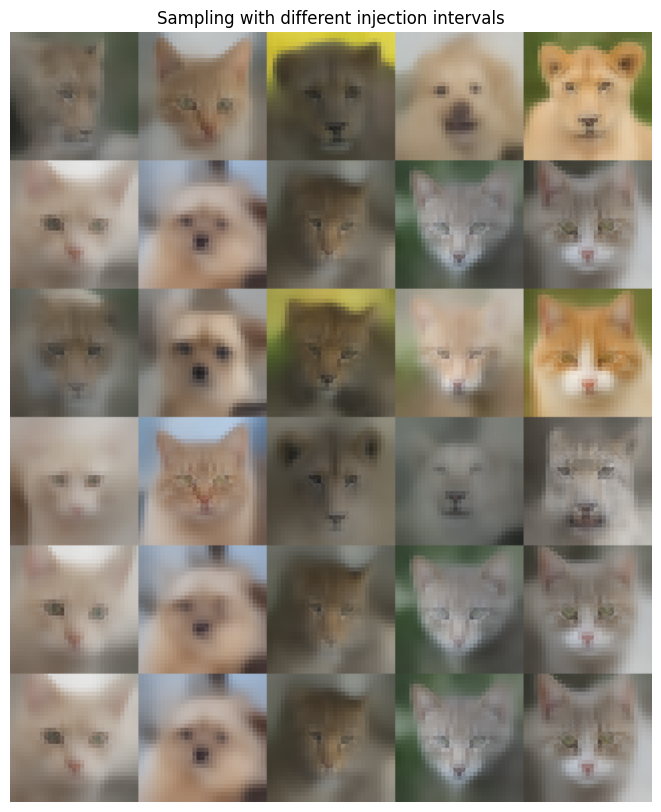

Sampling Bansal with step size of 150: 100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


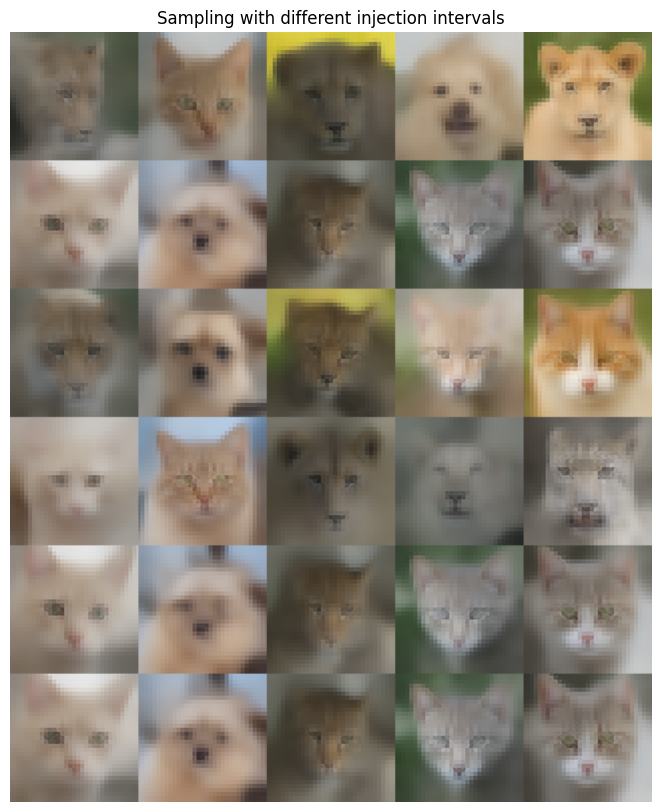

Sampling Bansal with step size of 100: 100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


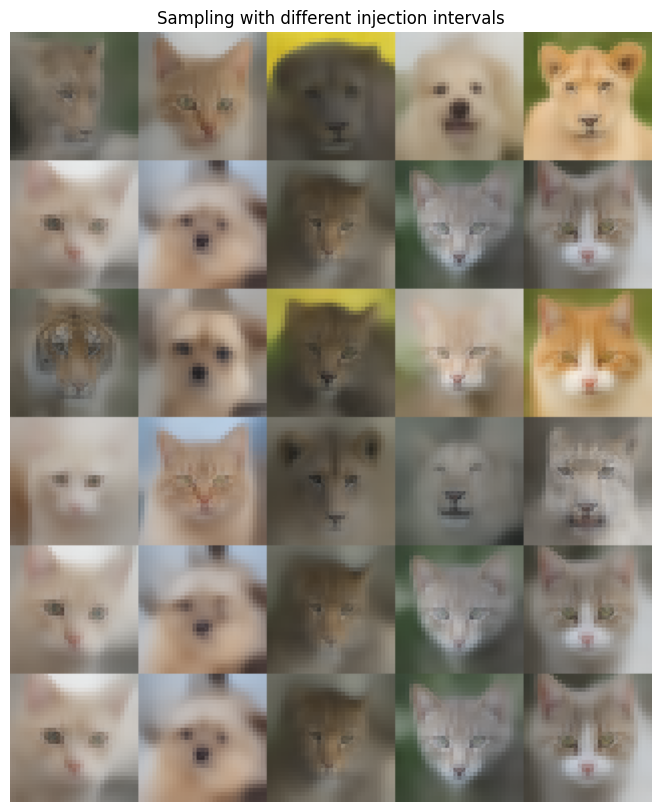

Sampling Bansal with step size of 50: 100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


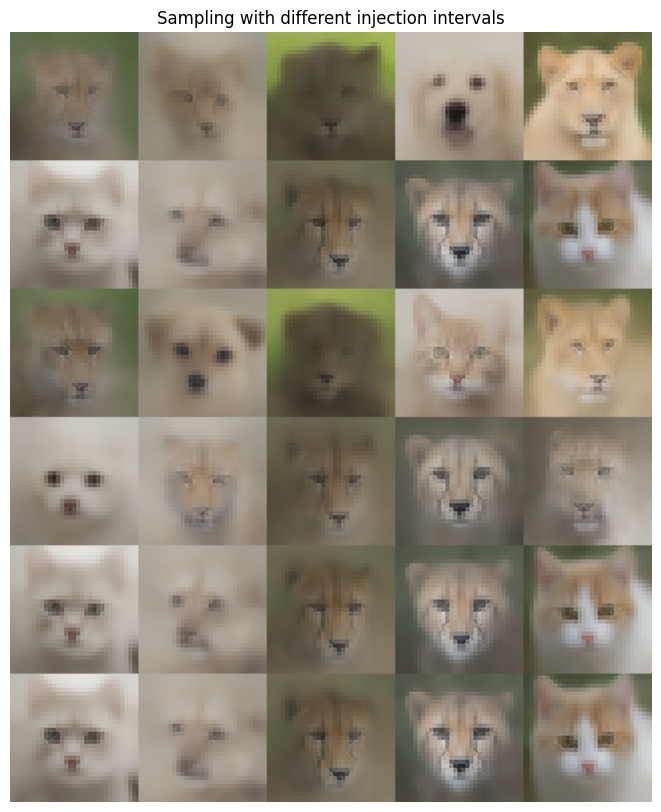

In [14]:
gridlist = []

for step_size in [200, 150, 100, 50]:
    
    plot_grid = torch.Tensor(style_sampler.xT[0:5]).unsqueeze(0)

    for inject_interval in [[200,-1], [-1,200], [200,150], [150,100], [100, 50], [50,-1]]:
        
        samples, xt = style_sampler.full_loop(step_size, 
                                            injection_t = inject_interval, 
                                            plot = False, 
                                            bansal_sampling = True,
                                            **kwargs)
        
        plot_grid = torch.cat((plot_grid, xt[:5].unsqueeze(0)), dim=0)

    plot_grid = torch.transpose(plot_grid, 0, 1) # Transpose to switch cols and rows in the grid
    plot_grid = plot_grid[:,1:,:,:,:] # Remove first xT
    plot_grid = plot_grid.reshape(-1, channels, kwargs['image_size'], kwargs['image_size'])

    gridlist.append(plot_grid)

    plt.figure(figsize=(20, 10))
    grid = make_grid(plot_grid, nrow=6, padding=0)
    grid = torch.clamp(grid, 0, 1)
    plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.title("Sampling with different injection intervals")
    plt.show()

# Data Feauture Transfer

Use VAE Encodings of true data and guide generation based on those features. Say we have an image with a green background that we want to transfer to another image, we can use the Encoding of that image early in the generation process to guide 

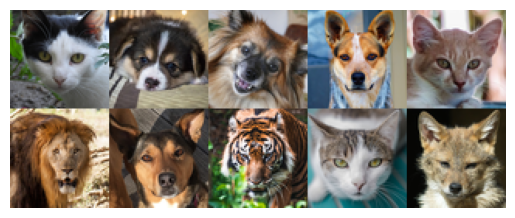

In [62]:
combi = torch.cat((x0[:5], x02[:5]), dim=0)
grid = make_grid(combi.cpu().detach(), nrow=5, padding=0)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

# RISANNEN REDEGRADATION EXPLORATION

In [57]:
class RisannenSampler():

    def __init__(self, trainer, **kwargs):
        self.model = trainer.model
        self.trainer = trainer
        self.timesteps = kwargs['timesteps']
        self.T = torch.full((kwargs['n_samples'],), self.timesteps-1, dtype=torch.long).to(kwargs['device'])
        self.xT = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device'])
        self.xT += torch.randn_like(self.xT, device=kwargs['device']) * kwargs['noise_scale'] # Add noise to xT
        self.target_prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.source_prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.dct = DCTBlurSampling(trainer.degradation.dct_blur.blur_sigmas, kwargs['image_size'], kwargs['device'])

    
    @torch.no_grad()
    def full_loop(self, step_size, injection_t = [200, 50], x0 = None, x02 = None, plot = True, bansal_sampling = True, **kwargs):
        
        xt = self.xT
        samples = torch.Tensor(xt[0:5])
        
        # Bansal-style sampling
        if bansal_sampling:
            skip_steps = 1
            bansal_flag = "Bansal"
        else:
            skip_steps = step_size-1 if step_size == self.timesteps else step_size
            bansal_flag = "Regular"
            
        # Loop differs from the sequential one, as we go back to t-1 at every step
        for i in tqdm(range(self.timesteps-1, -1, -skip_steps), total = self.timesteps // skip_steps, desc = f'Sampling {bansal_flag} with step size of {step_size}'):
            
            t = torch.full((kwargs['n_samples'],), i, dtype=torch.long).to(kwargs['device'])
            t2 = torch.full((kwargs['n_samples'],), i-step_size, dtype=torch.long).to(kwargs['device'])
            
            if t2[0].item() < 0: # Equals to x0 prediction
                t2 = torch.full((kwargs['n_samples'],), -1, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training

            # if not bansal_sampling:
            #     print(f"t = {t[0].item()}, t2 = {t2[0].item()}")
            
            # # Inject source information in a certain t range
            # # if x0 and / or x02 are not None, take the conditioning information from the encoded data,
            # if i < injection_t[0] and i > injection_t[1]:
            #     if x02 is not None:
            #         xt2 = self.trainer.degradation.degrade(x02, t)
            #         cond2 = self.trainer.degradation.degrade(x02, t2)
            #         dummy_pred = self.model(xt2, t, cond=cond2, prior=None, t2=t2).detach() # Dummy prediction to get the encoded VAE latent
            #         prior = self.model.vae_noise.detach() 
            #     else:
            #         prior = self.source_prior 
            #     cond = None # No condition for the model, such that is has to use the prior
            # else:
            #     if x0 is not None:
            #         cond = self.trainer.degradation.degrade(x0, t2)
            #         prior = None # No prior for the model, such that it has to use the condition
            #     else:
            #         cond = None
            #         prior = self.target_prior

            pred = self.model(xt, t, t2=None)
            pred = pred.detach()
            
            xtm1_model = xt + pred

            # In Risannen the noise is added to the predicted image, AFTER the model prediction
            if not i == 0:
                sampling_noise = torch.randn_like(xt, device=kwargs['device']) * kwargs['noise_scale'] * 1.25 # 1.25 is a scaling factor from the original Risannen Code (delta = 1.25 * sigma)
                xtm1_model = xtm1_model + sampling_noise  

            # Bansal Part
            if bansal_sampling:
                if step_size == self.timesteps:
                    
                    xt_hat = self.trainer.degradation.degrade(xtm1_model, t)
                    xtm1_hat = self.trainer.degradation.degrade(xtm1_model, t-1)
                    
                else:

                    # Calculcate reblurring for DCT
                    stdt = self.trainer.degradation.blur.dct_sigmas[t[0].item()]
                    stdtm1 = self.trainer.degradation.blur.dct_sigmas[t[0].item()-1]
                    stdt2 = self.trainer.degradation.blur.dct_sigmas[t2[0].item()] if t2[0].item() != -1 else 0

                    # Manually calculating DCT timesteps
                    t_dct = torch.full((kwargs['n_samples'],), stdt**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    tm1_dct = torch.full((kwargs['n_samples'],), stdtm1**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    t2_dct = torch.full((kwargs['n_samples'],), stdt2**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    
                    # Calculate DCT differences to get to t / t-1 from t2
                    t_diff_dct = t_dct - t2_dct
                    tm1_diff_dct = tm1_dct - t2_dct

                    print("Before Unblacking:", xtm1_model.mean())

                    # Undo Blacking
                    blacking_coef = self.trainer.degradation.blacking_coefs[t2[0].item()] if t2[0].item() != -1 else 1
                    xtm1_model = xtm1_model / blacking_coef
                    print(blacking_coef)
                    print("After Unblacking:", xtm1_model.mean())

                    # Reblur to t / t-1 from t2
                    xt_hat = self.dct(xtm1_model, t=t_diff_dct) 
                    if tm1_diff_dct[0].item() != 0:
                        xtm1_hat = self.dct(xtm1_model, t=tm1_diff_dct)
                    else:
                        xtm1_hat = xtm1_model

                    # Reapply Blacking
                    xt_hat = xt_hat * self.trainer.degradation.blacking_coefs[t[0].item()]
                    xtm1_hat = xtm1_hat * self.trainer.degradation.blacking_coefs[t[0].item() - 1]

                    print("After Reblacking:", xtm1_hat.mean())

                    if t[0].item()-1 == -1:
                        xtm1_hat = xtm1_model # Keep the original image for t=-1 (needed for Bansal style sampling)
                        #assert torch.equal(xtm1_hat[0], xtm1_model[0]), f"DCT reblurring failed, xtm1_hat is not equal to xtm1_model with xtm1_hat = {xtm1_hat[0,0,0]} and xtm1_model = {xtm1_model[0,0,0]}"
                    
                    # Check for NAs
                    if torch.isnan(xtm1_hat).any():
                        print("NAs in xtm1_hat")
                        self.investigate = [xt, xtm1_model, xtm1_hat]
                        plt.imshow(xt[0].cpu().detach().numpy().transpose(1, 2, 0)) 

                    assert not torch.isnan(xtm1_hat).any() 

                xt = xt - xt_hat + xtm1_hat # Counter the bias of the model prediction by having it incorporated two times in the sampling process
            
                print("Scales of the all:", xt.mean(), xt_hat.mean(), xtm1_hat.mean())

            else:

                # # In Risannen the noise is added to the predicted image, AFTER the model prediction
                # if not i == 0:
                #     sampling_noise = torch.randn_like(xt, device=kwargs['device']) * kwargs['noise_scale'] * 1.25 # 1.25 is a scaling factor from the original Risannen Code (delta = 1.25 * sigma)
                #     xtm1_model = xtm1_model + sampling_noise  

                xt = xtm1_model
                #samples = torch.cat((samples, xt[0:5]), dim=0)
                if t[0].item() < step_size:
                    break
            

            
            samples = torch.cat((samples, xt[0:5]), dim=0)

        
        if plot:
            self.plot(xt)
            save_gif(samples[::5,:,:], f'./imgs/experiment_imgs', nrow = 1, name = f"sample_DCT_{bansal_flag}_{step_size}.gif")

        return samples, xt
    



    def plot(self, input):
        plt.figure(figsize=(20, 10))
        grid = make_grid(input, nrow=10, padding=0)
        grid = torch.clamp(grid, 0, 1)
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()


risannen_sampler = RisannenSampler(trainer, **kwargs)

In [37]:
risannen_sampler.investigate[0].mean()

tensor(2.3211e+25, device='mps:0')

In [ ]:
plt.imshow(risannen_sampler.investigate[0].cpu().detach().numpy().transpose(1, 2, 0))

Sampling Bansal with step size of 1:   0%|          | 1/200 [00:01<05:14,  1.58s/it]

Before Unblacking: tensor(4.4637e-05, device='mps:0')
tensor([[[6.1320e-05]]], device='mps:0')
After Unblacking: tensor(0.7279, device='mps:0')
After Reblacking: tensor(4.4637e-05, device='mps:0')
Scales of the all: tensor(5.1534e-05, device='mps:0') tensor(0., device='mps:0') tensor(4.4637e-05, device='mps:0')


Sampling Bansal with step size of 1:   1%|          | 2/200 [00:01<02:29,  1.33it/s]

Before Unblacking: tensor(0.0001, device='mps:0')
tensor([[[0.0002]]], device='mps:0')
After Unblacking: tensor(0.5560, device='mps:0')
After Reblacking: tensor(0.0001, device='mps:0')
Scales of the all: tensor(0.0002, device='mps:0') tensor(3.4088e-05, device='mps:0') tensor(0.0001, device='mps:0')
Before Unblacking: tensor(0.0003, device='mps:0')
tensor([[[0.0006]]], device='mps:0')
After Unblacking: tensor(0.5363, device='mps:0')
After Reblacking: tensor(0.0003, device='mps:0')
Scales of the all: tensor(0.0003, device='mps:0') tensor(0.0001, device='mps:0') tensor(0.0003, device='mps:0')


Sampling Bansal with step size of 1:   2%|▎         | 5/200 [00:02<00:54,  3.55it/s]

Before Unblacking: tensor(0.0005, device='mps:0')
tensor([[[0.0010]]], device='mps:0')
After Unblacking: tensor(0.5290, device='mps:0')
After Reblacking: tensor(0.0005, device='mps:0')
Scales of the all: tensor(0.0005, device='mps:0') tensor(0.0003, device='mps:0') tensor(0.0005, device='mps:0')
Before Unblacking: tensor(0.0008, device='mps:0')
tensor([[[0.0015]]], device='mps:0')
After Unblacking: tensor(0.5241, device='mps:0')
After Reblacking: tensor(0.0008, device='mps:0')
Scales of the all: tensor(0.0008, device='mps:0') tensor(0.0005, device='mps:0') tensor(0.0008, device='mps:0')


Sampling Bansal with step size of 1:   4%|▎         | 7/200 [00:02<00:41,  4.69it/s]

Before Unblacking: tensor(0.0011, device='mps:0')
tensor([[[0.0022]]], device='mps:0')
After Unblacking: tensor(0.5212, device='mps:0')
After Reblacking: tensor(0.0011, device='mps:0')
Scales of the all: tensor(0.0012, device='mps:0') tensor(0.0008, device='mps:0') tensor(0.0011, device='mps:0')
Before Unblacking: tensor(0.0016, device='mps:0')
tensor([[[0.0030]]], device='mps:0')
After Unblacking: tensor(0.5202, device='mps:0')
After Reblacking: tensor(0.0016, device='mps:0')
Scales of the all: tensor(0.0016, device='mps:0') tensor(0.0011, device='mps:0') tensor(0.0016, device='mps:0')


Sampling Bansal with step size of 1:   4%|▍         | 9/200 [00:02<00:34,  5.47it/s]

Before Unblacking: tensor(0.0020, device='mps:0')
tensor([[[0.0039]]], device='mps:0')
After Unblacking: tensor(0.5204, device='mps:0')
After Reblacking: tensor(0.0020, device='mps:0')
Scales of the all: tensor(0.0021, device='mps:0') tensor(0.0016, device='mps:0') tensor(0.0020, device='mps:0')
Before Unblacking: tensor(0.0026, device='mps:0')
tensor([[[0.0050]]], device='mps:0')
After Unblacking: tensor(0.5218, device='mps:0')
After Reblacking: tensor(0.0026, device='mps:0')
Scales of the all: tensor(0.0026, device='mps:0') tensor(0.0020, device='mps:0') tensor(0.0026, device='mps:0')


Sampling Bansal with step size of 1:   5%|▌         | 10/200 [00:03<00:33,  5.62it/s]

Before Unblacking: tensor(0.0032, device='mps:0')
tensor([[[0.0061]]], device='mps:0')
After Unblacking: tensor(0.5243, device='mps:0')
After Reblacking: tensor(0.0032, device='mps:0')
Scales of the all: tensor(0.0032, device='mps:0') tensor(0.0026, device='mps:0') tensor(0.0032, device='mps:0')
Before Unblacking: tensor(0.0039, device='mps:0')
tensor([[[0.0074]]], device='mps:0')
After Unblacking: tensor(0.5275, device='mps:0')
After Reblacking: tensor(0.0039, device='mps:0')
Scales of the all: tensor(0.0039, device='mps:0') tensor(0.0032, device='mps:0') tensor(0.0039, device='mps:0')


Sampling Bansal with step size of 1:   6%|▋         | 13/200 [00:03<00:30,  6.17it/s]

Before Unblacking: tensor(0.0047, device='mps:0')
tensor([[[0.0088]]], device='mps:0')
After Unblacking: tensor(0.5307, device='mps:0')
After Reblacking: tensor(0.0047, device='mps:0')
Scales of the all: tensor(0.0046, device='mps:0') tensor(0.0039, device='mps:0') tensor(0.0047, device='mps:0')
Before Unblacking: tensor(0.0055, device='mps:0')
tensor([[[0.0103]]], device='mps:0')
After Unblacking: tensor(0.5333, device='mps:0')
After Reblacking: tensor(0.0055, device='mps:0')
Scales of the all: tensor(0.0055, device='mps:0') tensor(0.0047, device='mps:0') tensor(0.0055, device='mps:0')


Sampling Bansal with step size of 1:   7%|▋         | 14/200 [00:03<00:30,  6.06it/s]

Before Unblacking: tensor(0.0064, device='mps:0')
tensor([[[0.0120]]], device='mps:0')
After Unblacking: tensor(0.5350, device='mps:0')
After Reblacking: tensor(0.0064, device='mps:0')
Scales of the all: tensor(0.0063, device='mps:0') tensor(0.0055, device='mps:0') tensor(0.0064, device='mps:0')


Sampling Bansal with step size of 1:   8%|▊         | 16/200 [00:04<00:31,  5.77it/s]

Before Unblacking: tensor(0.0074, device='mps:0')
tensor([[[0.0137]]], device='mps:0')
After Unblacking: tensor(0.5361, device='mps:0')
After Reblacking: tensor(0.0074, device='mps:0')
Scales of the all: tensor(0.0073, device='mps:0') tensor(0.0064, device='mps:0') tensor(0.0074, device='mps:0')
Before Unblacking: tensor(0.0084, device='mps:0')
tensor([[[0.0156]]], device='mps:0')
After Unblacking: tensor(0.5367, device='mps:0')
After Reblacking: tensor(0.0084, device='mps:0')
Scales of the all: tensor(0.0083, device='mps:0') tensor(0.0074, device='mps:0') tensor(0.0084, device='mps:0')


Sampling Bansal with step size of 1:   9%|▉         | 18/200 [00:04<00:30,  6.04it/s]

Before Unblacking: tensor(0.0095, device='mps:0')
tensor([[[0.0176]]], device='mps:0')
After Unblacking: tensor(0.5372, device='mps:0')
After Reblacking: tensor(0.0095, device='mps:0')
Scales of the all: tensor(0.0094, device='mps:0') tensor(0.0084, device='mps:0') tensor(0.0095, device='mps:0')
Before Unblacking: tensor(0.0106, device='mps:0')
tensor([[[0.0197]]], device='mps:0')
After Unblacking: tensor(0.5378, device='mps:0')
After Reblacking: tensor(0.0106, device='mps:0')
Scales of the all: tensor(0.0105, device='mps:0') tensor(0.0095, device='mps:0') tensor(0.0106, device='mps:0')


Sampling Bansal with step size of 1:  10%|▉         | 19/200 [00:04<00:29,  6.11it/s]

Before Unblacking: tensor(0.0118, device='mps:0')
tensor([[[0.0220]]], device='mps:0')
After Unblacking: tensor(0.5384, device='mps:0')
After Reblacking: tensor(0.0118, device='mps:0')
Scales of the all: tensor(0.0117, device='mps:0') tensor(0.0106, device='mps:0') tensor(0.0118, device='mps:0')
Before Unblacking: tensor(0.0131, device='mps:0')
tensor([[[0.0243]]], device='mps:0')
After Unblacking: tensor(0.5389, device='mps:0')
After Reblacking: tensor(0.0131, device='mps:0')
Scales of the all: tensor(0.0130, device='mps:0') tensor(0.0118, device='mps:0') tensor(0.0131, device='mps:0')


Sampling Bansal with step size of 1:  11%|█         | 22/200 [00:04<00:28,  6.25it/s]

Before Unblacking: tensor(0.0145, device='mps:0')
tensor([[[0.0268]]], device='mps:0')
After Unblacking: tensor(0.5393, device='mps:0')
After Reblacking: tensor(0.0145, device='mps:0')
Scales of the all: tensor(0.0143, device='mps:0') tensor(0.0131, device='mps:0') tensor(0.0145, device='mps:0')
Before Unblacking: tensor(0.0159, device='mps:0')
tensor([[[0.0294]]], device='mps:0')
After Unblacking: tensor(0.5396, device='mps:0')
After Reblacking: tensor(0.0159, device='mps:0')
Scales of the all: tensor(0.0157, device='mps:0') tensor(0.0145, device='mps:0') tensor(0.0159, device='mps:0')


Sampling Bansal with step size of 1:  12%|█▏        | 24/200 [00:05<00:29,  6.06it/s]

Before Unblacking: tensor(0.0173, device='mps:0')
tensor([[[0.0321]]], device='mps:0')
After Unblacking: tensor(0.5397, device='mps:0')
After Reblacking: tensor(0.0173, device='mps:0')
Scales of the all: tensor(0.0172, device='mps:0') tensor(0.0159, device='mps:0') tensor(0.0173, device='mps:0')
Before Unblacking: tensor(0.0188, device='mps:0')
tensor([[[0.0349]]], device='mps:0')
After Unblacking: tensor(0.5398, device='mps:0')
After Reblacking: tensor(0.0188, device='mps:0')
Scales of the all: tensor(0.0187, device='mps:0') tensor(0.0173, device='mps:0') tensor(0.0188, device='mps:0')


Sampling Bansal with step size of 1:  13%|█▎        | 26/200 [00:05<00:27,  6.33it/s]

Before Unblacking: tensor(0.0204, device='mps:0')
tensor([[[0.0378]]], device='mps:0')
After Unblacking: tensor(0.5393, device='mps:0')
After Reblacking: tensor(0.0204, device='mps:0')
Scales of the all: tensor(0.0203, device='mps:0') tensor(0.0188, device='mps:0') tensor(0.0204, device='mps:0')
Before Unblacking: tensor(0.0221, device='mps:0')
tensor([[[0.0409]]], device='mps:0')
After Unblacking: tensor(0.5401, device='mps:0')
After Reblacking: tensor(0.0221, device='mps:0')
Scales of the all: tensor(0.0219, device='mps:0') tensor(0.0204, device='mps:0') tensor(0.0221, device='mps:0')


Sampling Bansal with step size of 1:  14%|█▎        | 27/200 [00:05<00:27,  6.38it/s]

Before Unblacking: tensor(0.0238, device='mps:0')
tensor([[[0.0440]]], device='mps:0')
After Unblacking: tensor(0.5401, device='mps:0')
After Reblacking: tensor(0.0238, device='mps:0')
Scales of the all: tensor(0.0236, device='mps:0') tensor(0.0221, device='mps:0') tensor(0.0238, device='mps:0')
Before Unblacking: tensor(0.0256, device='mps:0')
tensor([[[0.0473]]], device='mps:0')
After Unblacking: tensor(0.5403, device='mps:0')
After Reblacking: 

Sampling Bansal with step size of 1:  14%|█▍        | 29/200 [00:06<00:28,  6.10it/s]

tensor(0.0256, device='mps:0')
Scales of the all: tensor(0.0254, device='mps:0') tensor(0.0238, device='mps:0') tensor(0.0256, device='mps:0')
Before Unblacking: tensor(0.0274, device='mps:0')
tensor([[[0.0507]]], device='mps:0')
After Unblacking: tensor(0.5409, device='mps:0')
After Reblacking: tensor(0.0274, device='mps:0')
Scales of the all: tensor(0.0272, device='mps:0') tensor(0.0256, device='mps:0') tensor(0.0274, device='mps:0')


Sampling Bansal with step size of 1:  16%|█▌        | 31/200 [00:06<00:26,  6.36it/s]

Before Unblacking: tensor(0.0295, device='mps:0')
tensor([[[0.0542]]], device='mps:0')
After Unblacking: tensor(0.5454, device='mps:0')
After Reblacking: tensor(0.0295, device='mps:0')
Scales of the all: tensor(0.0291, device='mps:0') tensor(0.0276, device='mps:0') tensor(0.0295, device='mps:0')
Before Unblacking: tensor(0.0316, device='mps:0')
tensor([[[0.0578]]], device='mps:0')
After Unblacking: tensor(0.5466, device='mps:0')
After Reblacking: tensor(0.0316, device='mps:0')
Scales of the all: tensor(0.0311, device='mps:0') tensor(0.0296, device='mps:0') tensor(0.0316, device='mps:0')


Sampling Bansal with step size of 1:  16%|█▋        | 33/200 [00:06<00:25,  6.46it/s]

Before Unblacking: tensor(0.0338, device='mps:0')
tensor([[[0.0615]]], device='mps:0')
After Unblacking: tensor(0.5496, device='mps:0')
After Reblacking: tensor(0.0338, device='mps:0')
Scales of the all: tensor(0.0331, device='mps:0') tensor(0.0318, device='mps:0') tensor(0.0338, device='mps:0')
Before Unblacking: tensor(0.0363, device='mps:0')
tensor([[[0.0653]]], device='mps:0')
After Unblacking: tensor(0.5562, device='mps:0')
After Reblacking: tensor(0.0363, device='mps:0')
Scales of the all: tensor(0.0352, device='mps:0') tensor(0.0342, device='mps:0') tensor(0.0363, device='mps:0')


Sampling Bansal with step size of 1:  18%|█▊        | 35/200 [00:07<00:25,  6.54it/s]

Before Unblacking: tensor(0.0392, device='mps:0')
tensor([[[0.0692]]], device='mps:0')
After Unblacking: tensor(0.5669, device='mps:0')
After Reblacking: tensor(0.0392, device='mps:0')
Scales of the all: tensor(0.0375, device='mps:0') tensor(0.0370, device='mps:0') tensor(0.0392, device='mps:0')
Before Unblacking: tensor(0.0422, device='mps:0')
tensor([[[0.0733]]], device='mps:0')
After Unblacking: tensor(0.5761, device='mps:0')
After Reblacking: tensor(0.0422, device='mps:0')
Scales of the all: tensor(0.0398, device='mps:0') tensor(0.0399, device='mps:0') tensor(0.0422, device='mps:0')


Sampling Bansal with step size of 1:  18%|█▊        | 36/200 [00:07<00:25,  6.38it/s]

Before Unblacking: tensor(0.0450, device='mps:0')
tensor([[[0.0774]]], device='mps:0')
After Unblacking: tensor(0.5820, device='mps:0')
After Reblacking: tensor(0.0450, device='mps:0')
Scales of the all: tensor(0.0422, device='mps:0') tensor(0.0426, device='mps:0') tensor(0.0450, device='mps:0')
Before Unblacking: tensor(0.0476, device='mps:0')
tensor([[[0.0816]]], device='mps:0')
After Unblacking: tensor(0.5829, device='mps:0')
After Reblacking: tensor(0.0476, device='mps:0')
Scales of the all: tensor(0.0447, device='mps:0') tensor(0.0451, device='mps:0') tensor(0.0476, device='mps:0')


Sampling Bansal with step size of 1:  20%|█▉        | 39/200 [00:07<00:24,  6.57it/s]

Before Unblacking: tensor(0.0496, device='mps:0')
tensor([[[0.0860]]], device='mps:0')
After Unblacking: tensor(0.5769, device='mps:0')
After Reblacking: tensor(0.0496, device='mps:0')
Scales of the all: tensor(0.0472, device='mps:0') tensor(0.0471, device='mps:0') tensor(0.0496, device='mps:0')
Before Unblacking: tensor(0.0520, device='mps:0')
tensor([[[0.0904]]], device='mps:0')
After Unblacking: tensor(0.5751, device='mps:0')
After Reblacking: tensor(0.0520, device='mps:0')
Scales of the all: tensor(0.0497, device='mps:0') tensor(0.0494, device='mps:0') tensor(0.0520, device='mps:0')


Sampling Bansal with step size of 1:  20%|██        | 41/200 [00:07<00:25,  6.32it/s]

Before Unblacking: tensor(0.0546, device='mps:0')
tensor([[[0.0949]]], device='mps:0')
After Unblacking: tensor(0.5754, device='mps:0')
After Reblacking: tensor(0.0546, device='mps:0')
Scales of the all: tensor(0.0523, device='mps:0') tensor(0.0520, device='mps:0') tensor(0.0546, device='mps:0')
Before Unblacking: tensor(0.0573, device='mps:0')
tensor([[[0.0996]]], device='mps:0')
After Unblacking: tensor(0.5754, device='mps:0')
After Reblacking: tensor(0.0573, device='mps:0')
Scales of the all: tensor(0.0550, device='mps:0') tensor(0.0546, device='mps:0') tensor(0.0573, device='mps:0')


Sampling Bansal with step size of 1:  22%|██▏       | 43/200 [00:08<00:24,  6.46it/s]

Before Unblacking: tensor(0.0602, device='mps:0')
tensor([[[0.1043]]], device='mps:0')
After Unblacking: tensor(0.5769, device='mps:0')
After Reblacking: tensor(0.0602, device='mps:0')
Scales of the all: tensor(0.0577, device='mps:0') tensor(0.0575, device='mps:0') tensor(0.0602, device='mps:0')
Before Unblacking: tensor(0.0634, device='mps:0')
tensor([[[0.1092]]], device='mps:0')
After Unblacking: tensor(0.5804, device='mps:0')
After Reblacking: tensor(0.0634, device='mps:0')
Scales of the all: tensor(0.0605, device='mps:0') tensor(0.0605, device='mps:0') tensor(0.0634, device='mps:0')


Sampling Bansal with step size of 1:  22%|██▎       | 45/200 [00:08<00:23,  6.58it/s]

Before Unblacking: tensor(0.0664, device='mps:0')
tensor([[[0.1141]]], device='mps:0')
After Unblacking: tensor(0.5824, device='mps:0')
After Reblacking: tensor(0.0664, device='mps:0')
Scales of the all: tensor(0.0634, device='mps:0') tensor(0.0636, device='mps:0') tensor(0.0664, device='mps:0')
Before Unblacking: tensor(0.0690, device='mps:0')
tensor([[[0.1191]]], device='mps:0')
After Unblacking: tensor(0.5793, device='mps:0')
After Reblacking: tensor(0.0690, device='mps:0')
Scales of the all: tensor(0.0663, device='mps:0') tensor(0.0661, device='mps:0') tensor(0.0690, device='mps:0')


Sampling Bansal with step size of 1:  24%|██▎       | 47/200 [00:08<00:23,  6.60it/s]

Before Unblacking: tensor(0.0713, device='mps:0')
tensor([[[0.1242]]], device='mps:0')
After Unblacking: tensor(0.5741, device='mps:0')
After Reblacking: tensor(0.0713, device='mps:0')
Scales of the all: tensor(0.0693, device='mps:0') tensor(0.0684, device='mps:0') tensor(0.0713, device='mps:0')
Before Unblacking: tensor(0.0734, device='mps:0')
tensor([[[0.1295]]], device='mps:0')
After Unblacking: tensor(0.5669, device='mps:0')
After Reblacking: tensor(0.0734, device='mps:0')
Scales of the all: tensor(0.0722, device='mps:0') tensor(0.0704, device='mps:0') tensor(0.0734, device='mps:0')


Sampling Bansal with step size of 1:  24%|██▍       | 49/200 [00:09<00:22,  6.67it/s]

Before Unblacking: tensor(0.0754, device='mps:0')
tensor([[[0.1348]]], device='mps:0')
After Unblacking: tensor(0.5592, device='mps:0')
After Reblacking: tensor(0.0753, device='mps:0')
Scales of the all: tensor(0.0752, device='mps:0') tensor(0.0724, device='mps:0') tensor(0.0753, device='mps:0')
Before Unblacking: tensor(0.0776, device='mps:0')
tensor([[[0.1401]]], device='mps:0')
After Unblacking: tensor(0.5534, device='mps:0')
After Reblacking: tensor(0.0775, device='mps:0')
Scales of the all: tensor(0.0782, device='mps:0') tensor(0.0746, device='mps:0') tensor(0.0775, device='mps:0')


Sampling Bansal with step size of 1:  26%|██▌       | 51/200 [00:09<00:22,  6.69it/s]

Before Unblacking: tensor(0.0801, device='mps:0')
tensor([[[0.1456]]], device='mps:0')
After Unblacking: tensor(0.5498, device='mps:0')
After Reblacking: tensor(0.0801, device='mps:0')
Scales of the all: tensor(0.0812, device='mps:0') tensor(0.0770, device='mps:0') tensor(0.0801, device='mps:0')
Before Unblacking: tensor(0.0828, device='mps:0')
tensor([[[0.1512]]], device='mps:0')
After Unblacking: tensor(0.5478, device='mps:0')
After Reblacking: tensor(0.0828, device='mps:0')
Scales of the all: tensor(0.0843, device='mps:0') tensor(0.0798, device='mps:0') tensor(0.0828, device='mps:0')


Sampling Bansal with step size of 1:  26%|██▋       | 53/200 [00:09<00:21,  6.73it/s]

Before Unblacking: tensor(0.0856, device='mps:0')
tensor([[[0.1568]]], device='mps:0')
After Unblacking: tensor(0.5464, device='mps:0')
After Reblacking: tensor(0.0856, device='mps:0')
Scales of the all: tensor(0.0874, device='mps:0') tensor(0.0826, device='mps:0') tensor(0.0856, device='mps:0')
Before Unblacking: tensor(0.0886, device='mps:0')
tensor([[[0.1626]]], device='mps:0')
After Unblacking: tensor(0.5452, device='mps:0')
After Reblacking: tensor(0.0886, device='mps:0')
Scales of the all: tensor(0.0905, device='mps:0') tensor(0.0855, device='mps:0') tensor(0.0886, device='mps:0')


Sampling Bansal with step size of 1:  28%|██▊       | 55/200 [00:10<00:23,  6.29it/s]

Before Unblacking: tensor(0.0916, device='mps:0')
tensor([[[0.1684]]], device='mps:0')
After Unblacking: tensor(0.5441, device='mps:0')
After Reblacking: tensor(0.0916, device='mps:0')
Scales of the all: tensor(0.0936, device='mps:0') tensor(0.0884, device='mps:0') tensor(0.0916, device='mps:0')
Before Unblacking: tensor(0.0948, device='mps:0')
tensor([[[0.1743]]], device='mps:0')
After Unblacking: tensor(0.5445, device='mps:0')
After Reblacking: tensor(0.0946, device='mps:0')
Scales of the all: tensor(0.0965, device='mps:0') tensor(0.0915, device='mps:0') tensor(0.0946, device='mps:0')


Sampling Bansal with step size of 1:  28%|██▊       | 57/200 [00:10<00:22,  6.37it/s]

Before Unblacking: tensor(0.0975, device='mps:0')
tensor([[[0.1803]]], device='mps:0')
After Unblacking: tensor(0.5411, device='mps:0')
After Reblacking: tensor(0.0976, device='mps:0')
Scales of the all: tensor(0.1001, device='mps:0') tensor(0.0947, device='mps:0') tensor(0.0976, device='mps:0')
Before Unblacking: tensor(0.1010, device='mps:0')
tensor([[[0.1863]]], device='mps:0')
After Unblacking: tensor(0.5415, device='mps:0')
After Reblacking: tensor(0.1005, device='mps:0')
Scales of the all: tensor(0.1020, device='mps:0') tensor(0.0970, device='mps:0') tensor(0.1005, device='mps:0')


Sampling Bansal with step size of 1:  30%|██▉       | 59/200 [00:10<00:21,  6.53it/s]

Before Unblacking: tensor(0.1046, device='mps:0')
tensor([[[0.1925]]], device='mps:0')
After Unblacking: tensor(0.5245, device='mps:0')
After Reblacking: tensor(0.1043, device='mps:0')
Scales of the all: tensor(0.1080, device='mps:0') tensor(0.1004, device='mps:0') tensor(0.1043, device='mps:0')
Before Unblacking: tensor(0.1096, device='mps:0')
tensor([[[0.1987]]], device='mps:0')
After Unblacking: tensor(0.5484, device='mps:0')
After Reblacking: tensor(0.1111, device='mps:0')
Scales of the all: tensor(0.1177, device='mps:0') tensor(0.1056, device='mps:0') tensor(0.1111, device='mps:0')


Sampling Bansal with step size of 1:  30%|███       | 61/200 [00:11<00:21,  6.55it/s]

Before Unblacking: tensor(0.1139, device='mps:0')
tensor([[[0.2050]]], device='mps:0')
After Unblacking: tensor(0.5427, device='mps:0')
After Reblacking: tensor(0.1112, device='mps:0')
Scales of the all: tensor(0.1161, device='mps:0') tensor(0.1075, device='mps:0') tensor(0.1112, device='mps:0')
Before Unblacking: tensor(0.1221, device='mps:0')
tensor([[[0.2113]]], device='mps:0')
After Unblacking: tensor(0.5333, device='mps:0')
After Reblacking: tensor(0.1198, device='mps:0')
Scales of the all: tensor(0.1193, device='mps:0') tensor(0.1080, device='mps:0') tensor(0.1198, device='mps:0')


Sampling Bansal with step size of 1:  31%|███       | 62/200 [00:11<00:22,  6.26it/s]

Before Unblacking: tensor(0.1172, device='mps:0')
tensor([[[0.2178]]], device='mps:0')
After Unblacking: tensor(0.4750, device='mps:0')
After Reblacking: tensor(0.1063, device='mps:0')
Scales of the all: tensor(0.1542, device='mps:0') tensor(0.1206, device='mps:0') tensor(0.1063, device='mps:0')
Before Unblacking: tensor(0.1500, device='mps:0')
tensor([[[0.2243]]], device='mps:0')
After Unblacking: tensor(0.5333, device='mps:0')
After Reblacking: tensor(0.1510, device='mps:0')
Scales of the all: tensor(0.0125, device='mps:0') tensor(0.0969, device='mps:0') tensor(0.1510, device='mps:0')


Sampling Bansal with step size of 1:  32%|███▎      | 65/200 [00:11<00:21,  6.41it/s]

Before Unblacking: tensor(0.0208, device='mps:0')
tensor([[[0.2308]]], device='mps:0')
After Unblacking: tensor(0.2333, device='mps:0')
After Reblacking: tensor(0.0625, device='mps:0')
Scales of the all: tensor(-0.0292, device='mps:0') tensor(0.1068, device='mps:0') tensor(0.0625, device='mps:0')
Before Unblacking: tensor(-0.0417, device='mps:0')
tensor([[[0.2375]]], device='mps:0')
After Unblacking: tensor(0.6667, device='mps:0')
After Reblacking: tensor(-0.0292, device='mps:0')
Scales of the all: tensor(0.0750, device='mps:0') tensor(0.1635, device='mps:0') tensor(-0.0292, device='mps:0')


Sampling Bansal with step size of 1:  33%|███▎      | 66/200 [00:11<00:20,  6.45it/s]

Before Unblacking: tensor(0.1000, device='mps:0')
tensor([[[0.2442]]], device='mps:0')
After Unblacking: tensor(0.7333, device='mps:0')
After Reblacking: tensor(0.1000, device='mps:0')
Scales of the all: tensor(0.2167, device='mps:0') tensor(-0.0552, device='mps:0') tensor(0.1000, device='mps:0')
Before Unblacking: tensor(0.2500, device='mps:0')
tensor([[[0.2509]]], device='mps:0')
After Unblacking: tensor(1.0667, device='mps:0')
After Reblacking: 

Sampling Bansal with step size of 1:  34%|███▍      | 68/200 [00:12<00:21,  6.20it/s]

tensor(-0.0167, device='mps:0')
Scales of the all: tensor(-0.4000, device='mps:0') tensor(0.5667, device='mps:0') tensor(-0.0167, device='mps:0')
Before Unblacking: tensor(-0.3667, device='mps:0')
tensor([[[0.2577]]], device='mps:0')
After Unblacking: tensor(2., device='mps:0')
After Reblacking: tensor(1.2000, device='mps:0')
Scales of the all: tensor(-1.8667, device='mps:0') tensor(-0.0292, device='mps:0') tensor(1.2000, device='mps:0')


Sampling Bansal with step size of 1:  34%|███▍      | 69/200 [00:12<00:21,  6.16it/s]

Before Unblacking: tensor(-1.8667, device='mps:0')
tensor([[[0.2646]]], device='mps:0')
After Unblacking: tensor(-6.4000, device='mps:0')
After Reblacking: tensor(-0.9333, device='mps:0')
Scales of the all: tensor(-4.5333, device='mps:0') tensor(0.0417, device='mps:0') tensor(-0.9333, device='mps:0')
Before Unblacking: tensor(-4.5333, device='mps:0')
tensor([[[0.2716]]], device='mps:0')
After Unblacking: tensor(-14.9333, device='mps:0')
After Reblacking: tensor(-3.4667, device='mps:0')
Scales of the all: tensor(-2.9333, device='mps:0') tensor(-3.3750, device='mps:0') tensor(-3.4667, device='mps:0')


Sampling Bansal with step size of 1:  36%|███▌      | 72/200 [00:12<00:19,  6.47it/s]

Before Unblacking: tensor(-2.9333, device='mps:0')
tensor([[[0.2786]]], device='mps:0')
After Unblacking: tensor(9.6000, device='mps:0')
After Reblacking: tensor(-0.8000, device='mps:0')
Scales of the all: tensor(-10.6667, device='mps:0') tensor(-6.7000, device='mps:0') tensor(-0.8000, device='mps:0')
Before Unblacking: tensor(-10.6667, device='mps:0')
tensor([[[0.2856]]], device='mps:0')
After Unblacking: tensor(-14.9333, device='mps:0')
After Reblacking: tensor(-6.4000, device='mps:0')
Scales of the all: tensor(-12.8000, device='mps:0') tensor(14.5167, device='mps:0') tensor(-6.4000, device='mps:0')


Sampling Bansal with step size of 1:  37%|███▋      | 74/200 [00:13<00:19,  6.53it/s]

Before Unblacking: tensor(-12.8000, device='mps:0')
tensor([[[0.2927]]], device='mps:0')
After Unblacking: tensor(140.8000, device='mps:0')
After Reblacking: tensor(29.8667, device='mps:0')
Scales of the all: tensor(19.2000, device='mps:0') tensor(-26.3333, device='mps:0') tensor(29.8667, device='mps:0')
Before Unblacking: tensor(19.2000, device='mps:0')
tensor([[[0.2999]]], device='mps:0')
After Unblacking: tensor(273.0667, device='mps:0')
After Reblacking: tensor(68.2667, device='mps:0')
Scales of the all: tensor(-4.2667, device='mps:0') tensor(83.0667, device='mps:0') tensor(68.2667, device='mps:0')


Sampling Bansal with step size of 1:  38%|███▊      | 76/200 [00:13<00:18,  6.54it/s]

Before Unblacking: tensor(-4.2667, device='mps:0')
tensor([[[0.3071]]], device='mps:0')
After Unblacking: tensor(-102.4000, device='mps:0')
After Reblacking: tensor(68.2667, device='mps:0')
Scales of the all: tensor(34.1333, device='mps:0') tensor(-27.3333, device='mps:0') tensor(68.2667, device='mps:0')
Before Unblacking: tensor(34.1333, device='mps:0')
tensor([[[0.3143]]], device='mps:0')
After Unblacking: tensor(-375.4667, device='mps:0')
After Reblacking: tensor(25.6000, device='mps:0')
Scales of the all: tensor(-136.5333, device='mps:0') tensor(228.5333, device='mps:0') tensor(25.6000, device='mps:0')


Sampling Bansal with step size of 1:  39%|███▉      | 78/200 [00:13<00:18,  6.56it/s]

Before Unblacking: tensor(-136.5333, device='mps:0')
tensor([[[0.3216]]], device='mps:0')
After Unblacking: tensor(1092.2667, device='mps:0')
After Reblacking: tensor(102.4000, device='mps:0')
Scales of the all: tensor(341.3333, device='mps:0') tensor(-182.9333, device='mps:0') tensor(102.4000, device='mps:0')
Before Unblacking: tensor(341.3333, device='mps:0')
tensor([[[0.3289]]], device='mps:0')
After Unblacking: tensor(-3276.8003, device='mps:0')
After Reblacking: tensor(-68.2667, device='mps:0')
Scales of the all: tensor(1911.4668, device='mps:0') tensor(-133.3333, device='mps:0') tensor(-68.2667, device='mps:0')


Sampling Bansal with step size of 1:  40%|████      | 80/200 [00:14<00:19,  6.30it/s]

Before Unblacking: tensor(1911.4668, device='mps:0')
tensor([[[0.3363]]], device='mps:0')
After Unblacking: tensor(-5051.7334, device='mps:0')
After Reblacking: tensor(1433.6001, device='mps:0')
Scales of the all: tensor(1228.8000, device='mps:0') tensor(695.4667, device='mps:0') tensor(1433.6001, device='mps:0')
Before Unblacking: tensor(1228.8000, device='mps:0')
tensor([[[0.3437]]], device='mps:0')
After Unblacking: tensor(-9557.3340, device='mps:0')
After Reblacking: tensor(0., device='mps:0')
Scales of the all: tensor(4369.0669, device='mps:0') tensor(866.1334, device='mps:0') tensor(0., device='mps:0')


Sampling Bansal with step size of 1:  41%|████      | 82/200 [00:14<00:18,  6.44it/s]

Before Unblacking: tensor(4369.0669, device='mps:0')
tensor([[[0.3512]]], device='mps:0')
After Unblacking: tensor(-13653.3340, device='mps:0')
After Reblacking: tensor(3822.9336, device='mps:0')
Scales of the all: tensor(12561.0674, device='mps:0') tensor(3421.8669, device='mps:0') tensor(3822.9336, device='mps:0')
Before Unblacking: tensor(12561.0674, device='mps:0')
tensor([[[0.3587]]], device='mps:0')
After Unblacking: tensor(-16384., device='mps:0')
After Reblacking: tensor(-6553.6006, device='mps:0')
Scales of the all: tensor(-38229.3359, device='mps:0') tensor(6656.0005, device='mps:0') tensor(-6553.6006, device='mps:0')


Sampling Bansal with step size of 1:  42%|████▏     | 83/200 [00:14<00:18,  6.36it/s]

Before Unblacking: tensor(-38229.3359, device='mps:0')
tensor([[[0.3662]]], device='mps:0')
After Unblacking: tensor(-83012.2734, device='mps:0')
After Reblacking: tensor(-28398.9355, device='mps:0')
Scales of the all: tensor(2184.5334, device='mps:0') tensor(-22391.4688, device='mps:0') tensor(-28398.9355, device='mps:0')
Before Unblacking: tensor(2184.5334, device='mps:0')
tensor([[[0.3738]]], device='mps:0')
After Unblacking: tensor(-275251.2188, device='mps:0')
After Reblacking: tensor(-48059.7344, device='mps:0')
Scales of the all: tensor(104857.6094, device='mps:0') tensor(-130116.2734, device='mps:0') tensor(-48059.7344, device='mps:0')


Sampling Bansal with step size of 1:  43%|████▎     | 86/200 [00:14<00:17,  6.35it/s]

Before Unblacking: tensor(104857.6094, device='mps:0')
tensor([[[0.3814]]], device='mps:0')
After Unblacking: tensor(-17476.2676, device='mps:0')
After Reblacking: tensor(17476.2676, device='mps:0')
Scales of the all: tensor(227191.4844, device='mps:0') tensor(50995.2031, device='mps:0') tensor(17476.2676, device='mps:0')
Before Unblacking: tensor(227191.4844, device='mps:0')
tensor([[[0.3890]]], device='mps:0')
After Unblacking: tensor(279620.2812, device='mps:0')
After Reblacking: tensor(262144., device='mps:0')
Scales of the all: tensor(751479.5000, device='mps:0') tensor(-82056.5391, device='mps:0') tensor(262144., device='mps:0')


Sampling Bansal with step size of 1:  44%|████▍     | 88/200 [00:15<00:17,  6.45it/s]

Before Unblacking: tensor(751479.5000, device='mps:0')
tensor([[[0.3966]]], device='mps:0')
After Unblacking: tensor(1048576., device='mps:0')
After Reblacking: tensor(471859.2188, device='mps:0')
Scales of the all: tensor(-768955.7500, device='mps:0') tensor(404684.8125, device='mps:0') tensor(471859.2188, device='mps:0')
Before Unblacking: tensor(-768955.7500, device='mps:0')
tensor([[[0.4043]]], device='mps:0')
After Unblacking: tensor(2236962.2500, device='mps:0')
After Reblacking: tensor(-664098.1875, device='mps:0')
Scales of the all: tensor(699050.6875, device='mps:0') tensor(752025.6250, device='mps:0') tensor(-664098.1875, device='mps:0')


Sampling Bansal with step size of 1:  44%|████▍     | 89/200 [00:15<00:17,  6.37it/s]

Before Unblacking: tensor(699050.6875, device='mps:0')
tensor([[[0.4120]]], device='mps:0')
After Unblacking: tensor(3075823., device='mps:0')
After Reblacking: tensor(1677721.7500, device='mps:0')
Scales of the all: tensor(-1537911.5000, device='mps:0') tensor(157286.4062, device='mps:0') tensor(1677721.7500, device='mps:0')
Before Unblacking: tensor(-1537911.5000, device='mps:0')
tensor([[[0.4197]]], device='mps:0')
After Unblacking: tensor(7270127.5000, device='mps:0')
After Reblacking: tensor(-139810.1406, device='mps:0')
Scales of the all: tensor(6431266.5000, device='mps:0') tensor(413969.0938, device='mps:0') tensor(-139810.1406, device='mps:0')


Sampling Bansal with step size of 1:  46%|████▌     | 92/200 [00:15<00:17,  6.28it/s]

Before Unblacking: tensor(6431266.5000, device='mps:0')
tensor([[[0.4275]]], device='mps:0')
After Unblacking: tensor(17895698., device='mps:0')
After Reblacking: tensor(5033165., device='mps:0')
Scales of the all: tensor(13981014., device='mps:0') tensor(-6453112., device='mps:0') tensor(5033165., device='mps:0')
Before Unblacking: tensor(13981014., device='mps:0')
tensor([[[0.4352]]], device='mps:0')
After Unblacking: tensor(62634944., device='mps:0')
After Reblacking: tensor(13981014., device='mps:0')
Scales of the all: tensor(0., device='mps:0') tensor(11132382., device='mps:0') tensor(13981014., device='mps:0')


Sampling Bansal with step size of 1:  47%|████▋     | 94/200 [00:16<00:16,  6.49it/s]

Before Unblacking: tensor(0., device='mps:0')
tensor([[[0.4430]]], device='mps:0')
After Unblacking: tensor(76056720., device='mps:0')
After Reblacking: tensor(-4473924.5000, device='mps:0')
Scales of the all: tensor(78293680., device='mps:0') tensor(29259640., device='mps:0') tensor(-4473924.5000, device='mps:0')
Before Unblacking: tensor(78293680., device='mps:0')
tensor([[[0.4508]]], device='mps:0')
After Unblacking: tensor(-67108864., device='mps:0')
After Reblacking: tensor(40265320., device='mps:0')
Scales of the all: tensor(71582792., device='mps:0') tensor(60380504., device='mps:0') tensor(40265320., device='mps:0')


Sampling Bansal with step size of 1:  48%|████▊     | 96/200 [00:16<00:16,  6.45it/s]

Before Unblacking: tensor(71582792., device='mps:0')
tensor([[[0.4586]]], device='mps:0')
After Unblacking: tensor(1.7896e+08, device='mps:0')
After Reblacking: tensor(62634944., device='mps:0')
Scales of the all: tensor(1.0737e+08, device='mps:0') tensor(-1.4645e+08, device='mps:0') tensor(62634944., device='mps:0')
Before Unblacking: tensor(1.0737e+08, device='mps:0')
tensor([[[0.4664]]], device='mps:0')
After Unblacking: tensor(-1.4317e+08, device='mps:0')
After Reblacking: tensor(44739244., device='mps:0')
Scales of the all: tensor(6.4425e+08, device='mps:0') tensor(3.4624e+08, device='mps:0') tensor(44739244., device='mps:0')


Sampling Bansal with step size of 1:  49%|████▉     | 98/200 [00:16<00:15,  6.50it/s]

Before Unblacking: tensor(6.4425e+08, device='mps:0')
tensor([[[0.4742]]], device='mps:0')
After Unblacking: tensor(5.3687e+08, device='mps:0')
After Reblacking: tensor(5.0108e+08, device='mps:0')
Scales of the all: tensor(-3.2212e+08, device='mps:0') tensor(-63264088., device='mps:0') tensor(5.0108e+08, device='mps:0')
Before Unblacking: tensor(-3.2212e+08, device='mps:0')
tensor([[[0.4820]]], device='mps:0')
After Unblacking: tensor(2.3622e+09, device='mps:0')
After Reblacking: tensor(-2.1475e+08, device='mps:0')
Scales of the all: tensor(1.4317e+09, device='mps:0') tensor(9.1506e+08, device='mps:0') tensor(-2.1475e+08, device='mps:0')


Sampling Bansal with step size of 1:  50%|█████     | 100/200 [00:17<00:15,  6.45it/s]

Before Unblacking: tensor(1.4317e+09, device='mps:0')
tensor([[[0.4899]]], device='mps:0')
After Unblacking: tensor(2.7201e+09, device='mps:0')
After Reblacking: tensor(1.8612e+09, device='mps:0')
Scales of the all: tensor(-3.1496e+09, device='mps:0') tensor(8.7242e+08, device='mps:0') tensor(1.8612e+09, device='mps:0')
Before Unblacking: tensor(-3.1496e+09, device='mps:0')
tensor([[[0.4977]]], device='mps:0')
After Unblacking: tensor(-4.0086e+09, device='mps:0')
After Reblacking: tensor(-3.7223e+09, device='mps:0')
Scales of the all: tensor(-1.2026e+10, device='mps:0') tensor(5.3016e+08, device='mps:0') tensor(-3.7223e+09, device='mps:0')


Sampling Bansal with step size of 1:  51%|█████     | 102/200 [00:17<00:15,  6.48it/s]

Before Unblacking: tensor(-1.2026e+10, device='mps:0')
tensor([[[0.5055]]], device='mps:0')
After Unblacking: tensor(-6.8719e+09, device='mps:0')
After Reblacking: tensor(-1.0881e+10, device='mps:0')
Scales of the all: tensor(-2.1761e+10, device='mps:0') tensor(-3.1161e+09, device='mps:0') tensor(-1.0881e+10, device='mps:0')
Before Unblacking: tensor(-2.1761e+10, device='mps:0')
tensor([[[0.5133]]], device='mps:0')
After Unblacking: tensor(-1.1453e+10, device='mps:0')
After Reblacking: tensor(-2.0616e+10, device='mps:0')
Scales of the all: tensor(-3.8941e+10, device='mps:0') tensor(-2.5233e+09, device='mps:0') tensor(-2.0616e+10, device='mps:0')


Sampling Bansal with step size of 1:  52%|█████▏    | 103/200 [00:17<00:14,  6.56it/s]

Before Unblacking: tensor(-3.8941e+10, device='mps:0')
tensor([[[0.5212]]], device='mps:0')
After Unblacking: tensor(-7.3301e+10, device='mps:0')
After Reblacking: tensor(-4.1232e+10, device='mps:0')
Scales of the all: tensor(9.1626e+09, device='mps:0') tensor(-3.9245e+10, device='mps:0') tensor(-4.1232e+10, device='mps:0')
Before Unblacking: tensor(9.1626e+09, device='mps:0')
tensor([[[0.5290]]], device='mps:0')
After Unblacking: tensor(2.9778e+10, device='mps:0')


Sampling Bansal with step size of 1:  52%|█████▎    | 105/200 [00:17<00:15,  6.29it/s]

After Reblacking: tensor(-2.7488e+10, device='mps:0')
Scales of the all: tensor(-5.4976e+10, device='mps:0') tensor(-7.0509e+09, device='mps:0') tensor(-2.7488e+10, device='mps:0')
Before Unblacking: tensor(-5.4976e+10, device='mps:0')
tensor([[[0.5368]]], device='mps:0')
After Unblacking: tensor(3.6650e+10, device='mps:0')
After Reblacking: tensor(9.1626e+09, device='mps:0')
Scales of the all: tensor(-1.5576e+11, device='mps:0') tensor(-9.8641e+10, device='mps:0') tensor(9.1626e+09, device='mps:0')


Sampling Bansal with step size of 1:  54%|█████▎    | 107/200 [00:18<00:14,  6.52it/s]

Before Unblacking: tensor(-1.5576e+11, device='mps:0')
tensor([[[0.5446]]], device='mps:0')
After Unblacking: tensor(0., device='mps:0')
After Reblacking: tensor(-1.2828e+11, device='mps:0')
Scales of the all: tensor(-3.8483e+11, device='mps:0') tensor(2.7488e+10, device='mps:0') tensor(-1.2828e+11, device='mps:0')
Before Unblacking: tensor(-3.8483e+11, device='mps:0')
tensor([[[0.5524]]], device='mps:0')
After Unblacking: tensor(-1.0995e+11, device='mps:0')
After Reblacking: tensor(-2.0158e+11, device='mps:0')
Scales of the all: tensor(1.2461e+12, device='mps:0') tensor(4.3293e+11, device='mps:0') tensor(-2.0158e+11, device='mps:0')


Sampling Bansal with step size of 1:  55%|█████▍    | 109/200 [00:18<00:13,  6.55it/s]

Before Unblacking: tensor(1.2461e+12, device='mps:0')
tensor([[[0.5602]]], device='mps:0')
After Unblacking: tensor(-2.6388e+12, device='mps:0')
After Reblacking: tensor(2.1990e+11, device='mps:0')
Scales of the all: tensor(1.4660e+12, device='mps:0') tensor(3.7796e+11, device='mps:0') tensor(2.1990e+11, device='mps:0')
Before Unblacking: tensor(1.4660e+12, device='mps:0')
tensor([[[0.5679]]], device='mps:0')
After Unblacking: tensor(-4.9845e+12, device='mps:0')
After Reblacking: tensor(1.7592e+12, device='mps:0')
Scales of the all: tensor(-8.7961e+11, device='mps:0') tensor(5.3601e+11, device='mps:0') tensor(1.7592e+12, device='mps:0')


Sampling Bansal with step size of 1:  56%|█████▌    | 111/200 [00:18<00:13,  6.50it/s]

Before Unblacking: tensor(-8.7961e+11, device='mps:0')
tensor([[[0.5757]]], device='mps:0')
After Unblacking: tensor(8.7961e+11, device='mps:0')
After Reblacking: tensor(1.4660e+12, device='mps:0')
Scales of the all: tensor(1.0555e+13, device='mps:0') tensor(-4.2423e+12, device='mps:0') tensor(1.4660e+12, device='mps:0')
Before Unblacking: tensor(1.0555e+13, device='mps:0')
tensor([[[0.5834]]], device='mps:0')
After Unblacking: tensor(-1.1728e+13, device='mps:0')
After Reblacking: tensor(8.7961e+12, device='mps:0')
Scales of the all: tensor(-1.7592e+13, device='mps:0') tensor(7.3484e+12, device='mps:0') tensor(8.7961e+12, device='mps:0')


Sampling Bansal with step size of 1:  56%|█████▋    | 113/200 [00:19<00:13,  6.48it/s]

Before Unblacking: tensor(-1.7592e+13, device='mps:0')
tensor([[[0.5911]]], device='mps:0')
After Unblacking: tensor(9.3825e+12, device='mps:0')
After Reblacking: tensor(-5.8641e+12, device='mps:0')
Scales of the all: tensor(1.1728e+13, device='mps:0') tensor(-1.1398e+13, device='mps:0') tensor(-5.8641e+12, device='mps:0')
Before Unblacking: tensor(1.1728e+13, device='mps:0')
tensor([[[0.5988]]], device='mps:0')
After Unblacking: tensor(5.8641e+13, device='mps:0')
After Reblacking: tensor(5.3949e+13, device='mps:0')
Scales of the all: tensor(1.3605e+14, device='mps:0') tensor(4.2514e+13, device='mps:0') tensor(5.3949e+13, device='mps:0')


Sampling Bansal with step size of 1:  57%|█████▋    | 114/200 [00:19<00:13,  6.52it/s]

Before Unblacking: tensor(1.3605e+14, device='mps:0')
tensor([[[0.6065]]], device='mps:0')
After Unblacking: tensor(1.1259e+14, device='mps:0')
After Reblacking: tensor(6.5677e+13, device='mps:0')
Scales of the all: tensor(-1.9234e+14, device='mps:0') tensor(7.5060e+13, device='mps:0') tensor(6.5677e+13, device='mps:0')
Before Unblacking: tensor(-1.9234e+14, device='mps:0')
tensor([[[0.6141]]], device='mps:0')
After Unblacking: tensor(7.5060e+13, device='mps:0')
After Reblacking: tensor(-1.2666e+14, device='mps:0')
Scales of the all: 

Sampling Bansal with step size of 1:  58%|█████▊    | 116/200 [00:19<00:13,  6.33it/s]

tensor(-5.1604e+14, device='mps:0') tensor(1.1494e+14, device='mps:0') tensor(-1.2666e+14, device='mps:0')
Before Unblacking: tensor(-5.1604e+14, device='mps:0')
tensor([[[0.6217]]], device='mps:0')
After Unblacking: tensor(0., device='mps:0')
After Reblacking: tensor(-3.0024e+14, device='mps:0')
Scales of the all: tensor(-7.1307e+14, device='mps:0') tensor(8.6788e+13, device='mps:0') tensor(-3.0024e+14, device='mps:0')


Sampling Bansal with step size of 1:  59%|█████▉    | 118/200 [00:19<00:12,  6.42it/s]

Before Unblacking: tensor(-7.1307e+14, device='mps:0')
tensor([[[0.6293]]], device='mps:0')
After Unblacking: tensor(-7.8813e+14, device='mps:0')
After Reblacking: tensor(-4.8789e+14, device='mps:0')
Scales of the all: tensor(-1.1259e+14, device='mps:0') tensor(3.4481e+14, device='mps:0') tensor(-4.8789e+14, device='mps:0')
Before Unblacking: tensor(-1.1259e+14, device='mps:0')
tensor([[[0.6369]]], device='mps:0')
After Unblacking: tensor(9.7578e+14, device='mps:0')
After Reblacking: tensor(5.2542e+14, device='mps:0')
Scales of the all: tensor(-1.9516e+15, device='mps:0') tensor(1.1447e+15, device='mps:0') tensor(5.2542e+14, device='mps:0')


Sampling Bansal with step size of 1:  60%|██████    | 120/200 [00:20<00:12,  6.44it/s]

Before Unblacking: tensor(-1.9516e+15, device='mps:0')
tensor([[[0.6444]]], device='mps:0')
After Unblacking: tensor(-8.7070e+15, device='mps:0')
After Reblacking: tensor(3.4528e+15, device='mps:0')
Scales of the all: tensor(-1.8014e+15, device='mps:0') tensor(-2.5896e+15, device='mps:0') tensor(3.4528e+15, device='mps:0')
Before Unblacking: tensor(-1.8014e+15, device='mps:0')
tensor([[[0.6519]]], device='mps:0')
After Unblacking: tensor(-6.6053e+15, device='mps:0')
After Reblacking: tensor(-5.1041e+15, device='mps:0')
Scales of the all: tensor(-1.8014e+15, device='mps:0') tensor(-1.5763e+15, device='mps:0') tensor(-5.1041e+15, device='mps:0')


Sampling Bansal with step size of 1:  61%|██████    | 122/200 [00:20<00:11,  6.56it/s]

Before Unblacking: tensor(-1.8014e+15, device='mps:0')
tensor([[[0.6593]]], device='mps:0')
After Unblacking: tensor(1.4412e+16, device='mps:0')
After Reblacking: tensor(-1.8014e+15, device='mps:0')
Scales of the all: tensor(-8.4067e+15, device='mps:0') tensor(4.5036e+14, device='mps:0') tensor(-1.8014e+15, device='mps:0')
Before Unblacking: tensor(-8.4067e+15, device='mps:0')
tensor([[[0.6667]]], device='mps:0')
After Unblacking: tensor(2.1617e+16, device='mps:0')
After Reblacking: tensor(-1.2010e+16, device='mps:0')
Scales of the all: tensor(4.8038e+16, device='mps:0') tensor(-1.4261e+16, device='mps:0') tensor(-1.2010e+16, device='mps:0')


Sampling Bansal with step size of 1:  62%|██████▏   | 124/200 [00:20<00:11,  6.56it/s]

Before Unblacking: tensor(4.8038e+16, device='mps:0')
tensor([[[0.6741]]], device='mps:0')
After Unblacking: tensor(-1.2490e+17, device='mps:0')
After Reblacking: tensor(2.4019e+16, device='mps:0')
Scales of the all: tensor(5.7646e+16, device='mps:0') tensor(-8.4067e+15, device='mps:0') tensor(2.4019e+16, device='mps:0')
Before Unblacking: tensor(5.7646e+16, device='mps:0')
tensor([[[0.6814]]], device='mps:0')
After Unblacking: tensor(3.0745e+17, device='mps:0')
After Reblacking: tensor(1.2490e+17, device='mps:0')
Scales of the all: tensor(6.7254e+16, device='mps:0') tensor(-1.7774e+17, device='mps:0') tensor(1.2490e+17, device='mps:0')


Sampling Bansal with step size of 1:  62%|██████▎   | 125/200 [00:21<00:11,  6.46it/s]

Before Unblacking: tensor(6.7254e+16, device='mps:0')
tensor([[[0.6887]]], device='mps:0')
After Unblacking: tensor(1.3451e+18, device='mps:0')
After Reblacking: tensor(5.0921e+17, device='mps:0')
Scales of the all: tensor(1.0568e+18, device='mps:0') tensor(-4.2274e+17, device='mps:0') tensor(5.0921e+17, device='mps:0')
Before Unblacking: tensor(1.0568e+18, device='mps:0')
tensor([[[0.6959]]], device='mps:0')
After Unblacking: tensor(4.9960e+17, device='mps:0')


Sampling Bansal with step size of 1:  64%|██████▎   | 127/200 [00:21<00:11,  6.30it/s]

After Reblacking: tensor(4.6117e+17, device='mps:0')
Scales of the all: tensor(1.9215e+18, device='mps:0') tensor(1.9792e+18, device='mps:0') tensor(4.6117e+17, device='mps:0')
Before Unblacking: tensor(1.9215e+18, device='mps:0')
tensor([[[0.7031]]], device='mps:0')
After Unblacking: tensor(4.6117e+17, device='mps:0')
After Reblacking: tensor(2.8439e+18, device='mps:0')
Scales of the all: tensor(3.5356e+18, device='mps:0') tensor(-2.3058e+18, device='mps:0') tensor(2.8439e+18, device='mps:0')


Sampling Bansal with step size of 1:  64%|██████▍   | 129/200 [00:21<00:10,  6.50it/s]

Before Unblacking: tensor(3.5356e+18, device='mps:0')
tensor([[[0.7102]]], device='mps:0')
After Unblacking: tensor(1.9984e+19, device='mps:0')
After Reblacking: tensor(2.7670e+18, device='mps:0')
Scales of the all: tensor(1.1068e+19, device='mps:0') tensor(1.7678e+18, device='mps:0') tensor(2.7670e+18, device='mps:0')
Before Unblacking: tensor(1.1068e+19, device='mps:0')
tensor([[[0.7173]]], device='mps:0')
After Unblacking: tensor(1.5987e+19, device='mps:0')
After Reblacking: tensor(2.5211e+19, device='mps:0')
Scales of the all: tensor(4.5502e+19, device='mps:0') tensor(5.8722e+19, device='mps:0') tensor(2.5211e+19, device='mps:0')


Sampling Bansal with step size of 1:  66%|██████▌   | 131/200 [00:21<00:10,  6.50it/s]

Before Unblacking: tensor(4.5502e+19, device='mps:0')
tensor([[[0.7243]]], device='mps:0')
After Unblacking: tensor(-1.3282e+20, device='mps:0')
After Reblacking: tensor(4.1813e+19, device='mps:0')
Scales of the all: tensor(-1.8693e+20, device='mps:0') tensor(4.1198e+19, device='mps:0') tensor(4.1813e+19, device='mps:0')
Before Unblacking: tensor(-1.8693e+20, device='mps:0')
tensor([[[0.7313]]], device='mps:0')
After Unblacking: tensor(-2.7055e+20, device='mps:0')
After Reblacking: tensor(-9.8383e+19, device='mps:0')
Scales of the all: tensor(-4.0337e+20, device='mps:0') tensor(-1.3036e+20, device='mps:0') tensor(-9.8383e+19, device='mps:0')


Sampling Bansal with step size of 1:  66%|██████▋   | 133/200 [00:22<00:10,  6.51it/s]

Before Unblacking: tensor(-4.0337e+20, device='mps:0')
tensor([[[0.7382]]], device='mps:0')
After Unblacking: tensor(9.8383e+19, device='mps:0')
After Reblacking: tensor(-9.8383e+18, device='mps:0')
Scales of the all: tensor(-1.5938e+21, device='mps:0') tensor(1.8693e+20, device='mps:0') tensor(-9.8383e+18, device='mps:0')
Before Unblacking: tensor(-1.5938e+21, device='mps:0')
tensor([[[0.7450]]], device='mps:0')
After Unblacking: tensor(-1.2003e+21, device='mps:0')
After Reblacking: tensor(1.3774e+20, device='mps:0')
Scales of the all: tensor(-2.2038e+21, device='mps:0') tensor(-9.8383e+20, device='mps:0') tensor(1.3774e+20, device='mps:0')


Sampling Bansal with step size of 1:  67%|██████▋   | 134/200 [00:23<00:22,  2.96it/s]

Before Unblacking: tensor(-2.2038e+21, device='mps:0')
tensor([[[0.7518]]], device='mps:0')
After Unblacking: tensor(-7.8706e+20, device='mps:0')
After Reblacking: tensor(-3.1876e+21, device='mps:0')
Scales of the all: tensor(1.1649e+22, device='mps:0') tensor(-4.4862e+21, device='mps:0') tensor(-3.1876e+21, device='mps:0')
Before Unblacking: tensor(1.1649e+22, device='mps:0')
tensor([[[0.7586]]], device='mps:0')
After Unblacking: tensor(-2.2038e+21, device='mps:0')
After Reblacking: tensor(7.2410e+21, device='mps:0')


Sampling Bansal with step size of 1:  68%|██████▊   | 135/200 [00:23<00:18,  3.44it/s]

Scales of the all: tensor(-1.7630e+22, device='mps:0') tensor(4.0927e+21, device='mps:0') tensor(7.2410e+21, device='mps:0')
Before Unblacking: tensor(-1.7630e+22, device='mps:0')
tensor([[[0.7652]]], device='mps:0')
After Unblacking: tensor(-2.7705e+22, device='mps:0')
After Reblacking: tensor(-2.7705e+22, device='mps:0')
Scales of the all: tensor(-3.4001e+22, device='mps:0') tensor(-3.1168e+22, device='mps:0') tensor(-2.7705e+22, device='mps:0')


Sampling Bansal with step size of 1:  69%|██████▉   | 138/200 [00:23<00:12,  4.83it/s]

Before Unblacking: tensor(-3.4001e+22, device='mps:0')
tensor([[[0.7719]]], device='mps:0')
After Unblacking: tensor(-4.0298e+22, device='mps:0')
After Reblacking: tensor(1.2593e+21, device='mps:0')
Scales of the all: tensor(9.5707e+22, device='mps:0') tensor(4.0298e+22, device='mps:0') tensor(1.2593e+21, device='mps:0')
Before Unblacking: tensor(9.5707e+22, device='mps:0')
tensor([[[0.7784]]], device='mps:0')
After Unblacking: tensor(4.0298e+22, device='mps:0')
After Reblacking: tensor(1.4608e+23, device='mps:0')
Scales of the all: tensor(1.0074e+22, device='mps:0') tensor(-3.0223e+22, device='mps:0') tensor(1.4608e+23, device='mps:0')


Sampling Bansal with step size of 1:  70%|██████▉   | 139/200 [00:23<00:11,  5.15it/s]

Before Unblacking: tensor(1.0074e+22, device='mps:0')
tensor([[[0.7849]]], device='mps:0')
After Unblacking: tensor(-5.0372e+23, device='mps:0')
After Reblacking: tensor(2.0149e+22, device='mps:0')
Scales of the all: tensor(6.4476e+23, device='mps:0') tensor(1.0074e+22, device='mps:0') tensor(2.0149e+22, device='mps:0')
Before Unblacking: tensor(6.4476e+23, device='mps:0')
tensor([[[0.7913]]], device='mps:0')
After Unblacking: tensor(5.2387e+23, device='mps:0')
After Reblacking: tensor(4.4327e+23, device='mps:0')
Scales of the all: tensor(0., device='mps:0') tensor(-1.0880e+24, device='mps:0') 

Sampling Bansal with step size of 1:  70%|███████   | 141/200 [00:24<00:10,  5.48it/s]

tensor(4.4327e+23, device='mps:0')
Before Unblacking: tensor(0., device='mps:0')
tensor([[[0.7976]]], device='mps:0')
After Unblacking: tensor(-4.0298e+23, device='mps:0')
After Reblacking: tensor(1.0477e+24, device='mps:0')
Scales of the all: tensor(3.3850e+24, device='mps:0') tensor(4.5133e+24, device='mps:0') tensor(1.0477e+24, device='mps:0')


Sampling Bansal with step size of 1:  71%|███████   | 142/200 [00:24<00:10,  5.71it/s]

Before Unblacking: tensor(3.3850e+24, device='mps:0')
tensor([[[0.8038]]], device='mps:0')
After Unblacking: tensor(-4.1909e+24, device='mps:0')
After Reblacking: tensor(2.9014e+24, device='mps:0')
Scales of the all: tensor(3.5462e+25, device='mps:0') tensor(-1.4185e+25, device='mps:0') tensor(2.9014e+24, device='mps:0')
Before Unblacking: tensor(nan, device='mps:0')
tensor([[[0.8100]]], device='mps:0')
After Unblacking: tensor(nan, device='mps:0')
After Reblacking: tensor(nan, device='mps:0')
NAs in xtm1_hat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Sampling Bansal with step size of 1:  71%|███████   | 142/200 [00:24<00:10,  5.78it/s]


AssertionError: 

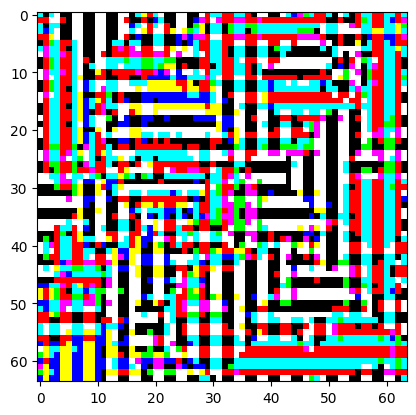

In [58]:

num_rows = 1

plot_grid = torch.Tensor(risannen_sampler.xT[0:5]).unsqueeze(0)
title_flag = "Risannen Generation"

step_size = 1
for sample_style in [True]:
    
    samples, xt = risannen_sampler.full_loop(step_size, 
                                            plot = False, 
                                            bansal_sampling = sample_style,
                                            **kwargs)
    
    plot_grid = torch.cat((plot_grid, xt[:5].unsqueeze(0)), dim=0)

plot_grid = torch.transpose(plot_grid, 0, 1) # Transpose to switch cols and rows in the grid
#if not use_x:
plot_grid = plot_grid[:,1:,:,:,:] # Remove first xT
plot_grid = plot_grid.reshape(-1, channels, kwargs['image_size'], kwargs['image_size'])

plt.figure(figsize=(20, 10))
grid = make_grid(plot_grid, nrow=num_rows, padding=0)
grid = torch.clamp(grid, 0, 1)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title(f"{title_flag} with and without Redegradation Sampling \n")
plt.show()
